In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import importlib
import funciones
importlib.reload(funciones)

<module 'funciones' from '/home/tux/proyecto_final_intro_cd/funciones.py'>

## 1. Comprensión del problema y del dataset

In [2]:
covid_panama_raw_df = pd.read_csv('./data/covid19_Panama_10-05-2020.csv')
covid_panama_raw_df.head()

,OBJECTID,PROVINCIA,DISTRITO,CORREGIMIENTO,CANTIDAD,HOSPITALIZADO,AISLAMIENTO_DOMICILIARIO,FALLECIDO,UCI,RECUPERADO,LONG,LAT,GlobalID
0,1,BOCAS DEL TORO,ALMIRANTE,ALMIRANTE,1.0,0.0,1.0,0.0,0.0,0.0,346352.2773,1.030528e+06,78a7066b-dd3c-495d-8030-ce63e39dd394
1,2,BOCAS DEL TORO,ALMIRANTE,BARRIADA GUAYMI,1.0,0.0,1.0,0.0,0.0,0.0,342522.3625,1.028730e+06,a09e8e0c-d93a-4232-bfa8-557046d43c44
2,3,BOCAS DEL TORO,ALMIRANTE,BARRIO FRANCES,NaN,NaN,NaN,NaN,NaN,NaN,349406.2891,1.028417e+06,c3b21f87-6851-4ca0-abc8-c23536023c8e
3,4,BOCAS DEL TORO,ALMIRANTE,NANCE DEL RISCO,NaN,NaN,NaN,NaN,NaN,NaN,318747.8223,1.002572e+06,3572df5c-ebcc-4304-88c8-0ff27f3dff3e
4,5,BOCAS DEL TORO,ALMIRANTE,VALLE DE AGUA ARRIBA,NaN,NaN,NaN,NaN,NaN,NaN,349040.0681,1.019400e+06,ce924bbb-fefa-49f4-a779-050e0b5309dc


In [3]:
covid_panama_df = covid_panama_raw_df.drop(['OBJECTID', 'GlobalID'], axis=1)
covid_panama_df.shape

(677, 11)

In [4]:
(
    covid_panama_df
    .dtypes
    .value_counts()
)

float64    8
object     3
Name: count, dtype: int64

In [5]:
covid_panama_df.describe()

,CANTIDAD,HOSPITALIZADO,AISLAMIENTO_DOMICILIARIO,FALLECIDO,UCI,RECUPERADO,LONG,LAT
count,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,677.000000,6.770000e+02
mean,37.184211,1.065789,15.868421,1.065789,0.403509,18.780702,526559.608513,9.321894e+05
std,70.410197,3.273181,27.914127,2.717226,1.139745,39.425781,132405.251236,5.679961e+04
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,288636.430400,8.041394e+05
25%,1.750000,0.000000,1.000000,0.000000,0.000000,0.000000,425527.613300,8.877641e+05
50%,4.000000,0.000000,3.000000,0.000000,0.000000,1.000000,537765.387700,9.320807e+05
75%,33.000000,1.000000,15.500000,1.000000,0.000000,10.250000,607056.018900,9.728446e+05
max,460.000000,39.000000,198.000000,19.000000,7.000000,214.000000,895852.727200,1.061314e+06


In [ ]:
print("Cantidad de duplicados: ", covid_panama_df.duplicated().sum())
covid_panama_df.describe(include=object)

Cantidad de duplicados:  0


,PROVINCIA,DISTRITO,CORREGIMIENTO
count,677,677,677
unique,13,82,620
top,VERAGUAS,PANAMÁ,SAN JOSE
freq,104,25,5


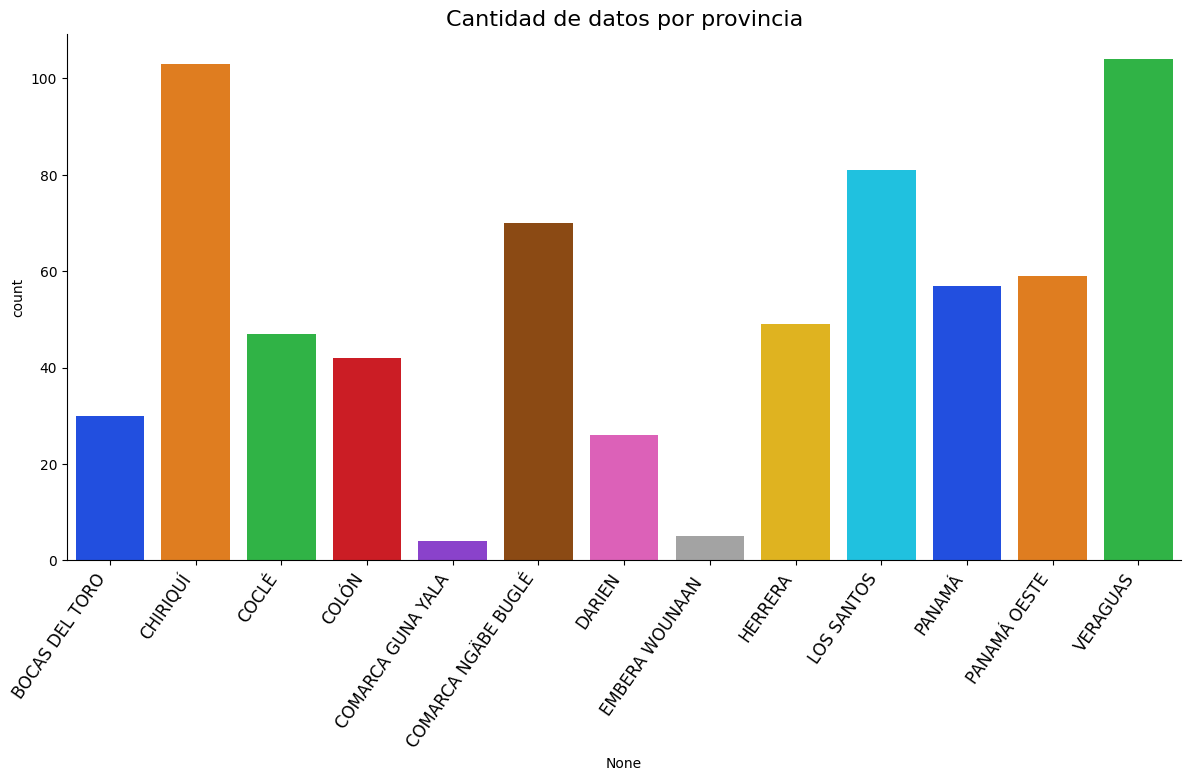

In [7]:
palette = sns.color_palette("bright", n_colors=covid_panama_df['PROVINCIA'].nunique())
sns.catplot(
        data = covid_panama_df,
        x = 'PROVINCIA',
        kind = 'count',
        hue='PROVINCIA',
        palette=palette,
        height = 6,
        aspect = 2,
        legend=False
    )

plt.xticks(rotation=55, fontsize=12, ha='right')
plt.xlabel('None')
plt.title('Cantidad de datos por provincia', fontsize=16)
plt.show()

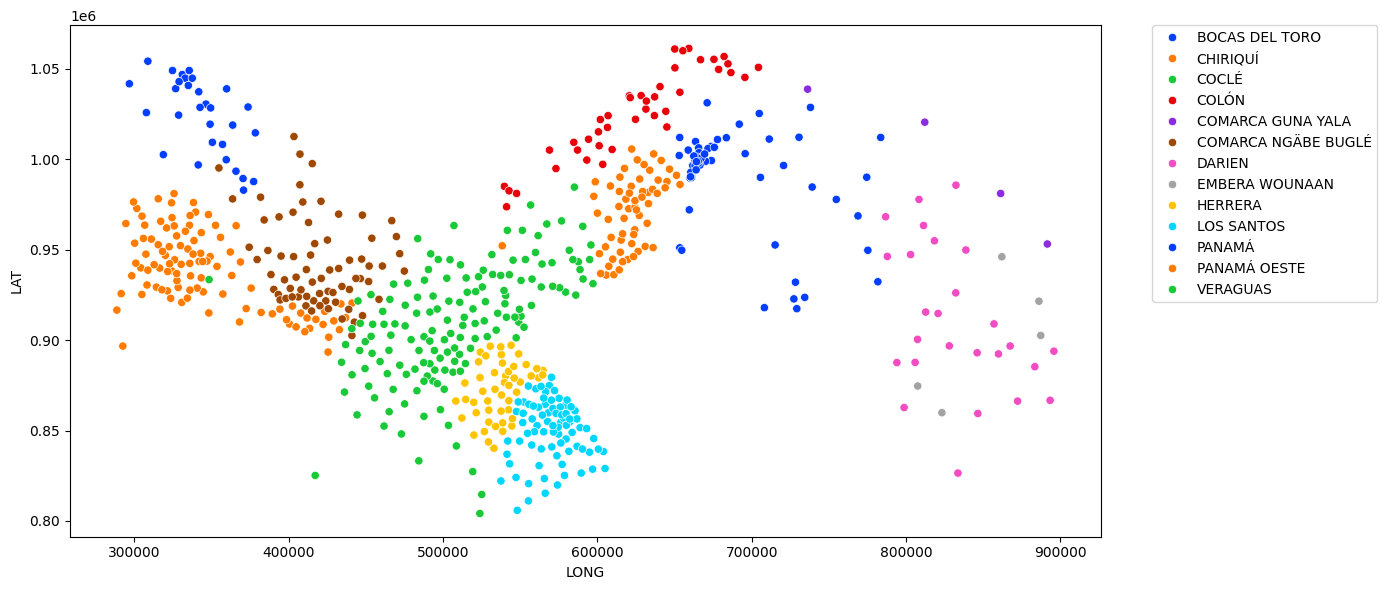

In [8]:
plt.figure(figsize=(14, 6))
sns.scatterplot(
    data=covid_panama_df, 
    x='LONG', 
    y='LAT',
    hue='PROVINCIA',
    palette=palette,
    legend=True
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()

plt.show()

In [9]:
covid_por_provincia_df = covid_panama_df.groupby('PROVINCIA')[['CANTIDAD', 'HOSPITALIZADO', 'UCI', 'AISLAMIENTO_DOMICILIARIO', 'FALLECIDO', 'RECUPERADO']].sum()
print(covid_por_provincia_df)

                     CANTIDAD  HOSPITALIZADO   UCI  AISLAMIENTO_DOMICILIARIO  \
PROVINCIA                                                                      
BOCAS DEL TORO           53.0            2.0   0.0                      44.0   
CHIRIQUÍ                124.0            3.0   1.0                      83.0   
COCLÉ                    97.0            3.0   0.0                      70.0   
COLÓN                   346.0            7.0   3.0                     210.0   
COMARCA GUNA YALA       192.0           14.0   3.0                     120.0   
COMARCA NGÄBE BUGLÉ      62.0            1.0   0.0                      61.0   
DARIEN                  176.0            1.0   1.0                     109.0   
EMBERA WOUNAAN            5.0            0.0   0.0                       5.0   
HERRERA                  23.0            2.0   1.0                      17.0   
LOS SANTOS               16.0            0.0   0.0                      15.0   
PANAMÁ                 5145.0          1

In [10]:
covid_por_provincia_df = covid_panama_df.groupby('PROVINCIA')[['CANTIDAD', 'HOSPITALIZADO', 'UCI', 'AISLAMIENTO_DOMICILIARIO', 'FALLECIDO', 'RECUPERADO']].sum()
covid_por_provincia_df

,CANTIDAD,HOSPITALIZADO,UCI,AISLAMIENTO_DOMICILIARIO,FALLECIDO,RECUPERADO
PROVINCIA,,,,,,
BOCAS DEL TORO,53.0,2.0,0.0,44.0,0.0,7.0
CHIRIQUÍ,124.0,3.0,1.0,83.0,5.0,32.0
COCLÉ,97.0,3.0,0.0,70.0,3.0,21.0
COLÓN,346.0,7.0,3.0,210.0,6.0,120.0
COMARCA GUNA YALA,192.0,14.0,3.0,120.0,8.0,47.0
COMARCA NGÄBE BUGLÉ,62.0,1.0,0.0,61.0,0.0,0.0
DARIEN,176.0,1.0,1.0,109.0,1.0,64.0
EMBERA WOUNAAN,5.0,0.0,0.0,5.0,0.0,0.0
HERRERA,23.0,2.0,1.0,17.0,1.0,2.0


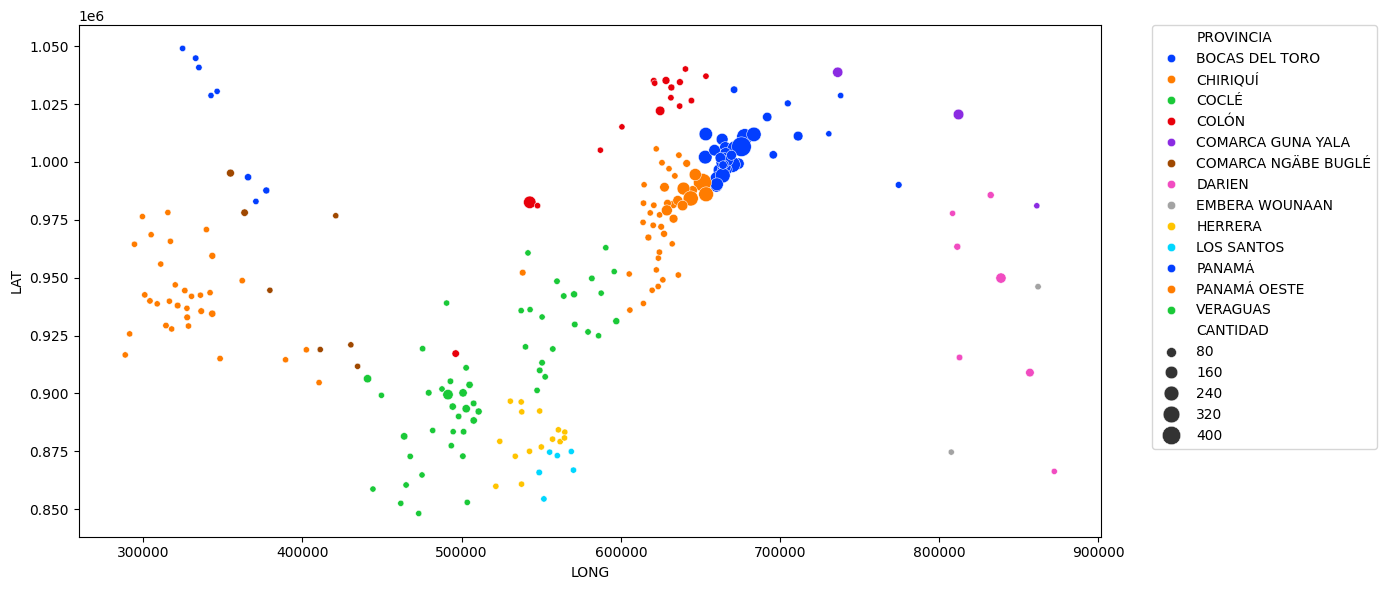

In [11]:
palette = sns.color_palette("bright", n_colors=covid_panama_df['PROVINCIA'].nunique())
plt.figure(figsize=(14, 6))
sns.scatterplot(
    data=covid_panama_df, 
    x='LONG', 
    y='LAT',
    hue='PROVINCIA',
    size='CANTIDAD',
    sizes=(20, 200),
    palette=palette,
    legend=True
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()

plt.show()

In [12]:
covid_chiriqui_df = covid_panama_df[covid_panama_df['PROVINCIA'] == 'CHIRIQUÍ']
covid_chiriqui_by_distrito_df = covid_chiriqui_df.groupby('DISTRITO')[['CANTIDAD', 'HOSPITALIZADO', 'UCI', 'AISLAMIENTO_DOMICILIARIO', 'FALLECIDO', 'RECUPERADO']].sum()
covid_chiriqui_by_distrito_df

,CANTIDAD,HOSPITALIZADO,UCI,AISLAMIENTO_DOMICILIARIO,FALLECIDO,RECUPERADO
DISTRITO,,,,,,
ALANJE,17.0,1.0,0.0,9.0,0.0,7.0
BARÚ,3.0,0.0,0.0,3.0,0.0,0.0
BOQUERÓN,6.0,0.0,0.0,5.0,0.0,1.0
BOQUETE,17.0,0.0,0.0,15.0,0.0,2.0
BUGABA,20.0,0.0,1.0,13.0,0.0,6.0
DAVID,43.0,2.0,0.0,29.0,1.0,11.0
DOLEGA,2.0,0.0,0.0,2.0,0.0,0.0
GUALACA,4.0,0.0,0.0,0.0,2.0,2.0
REMEDIOS,2.0,0.0,0.0,1.0,0.0,1.0


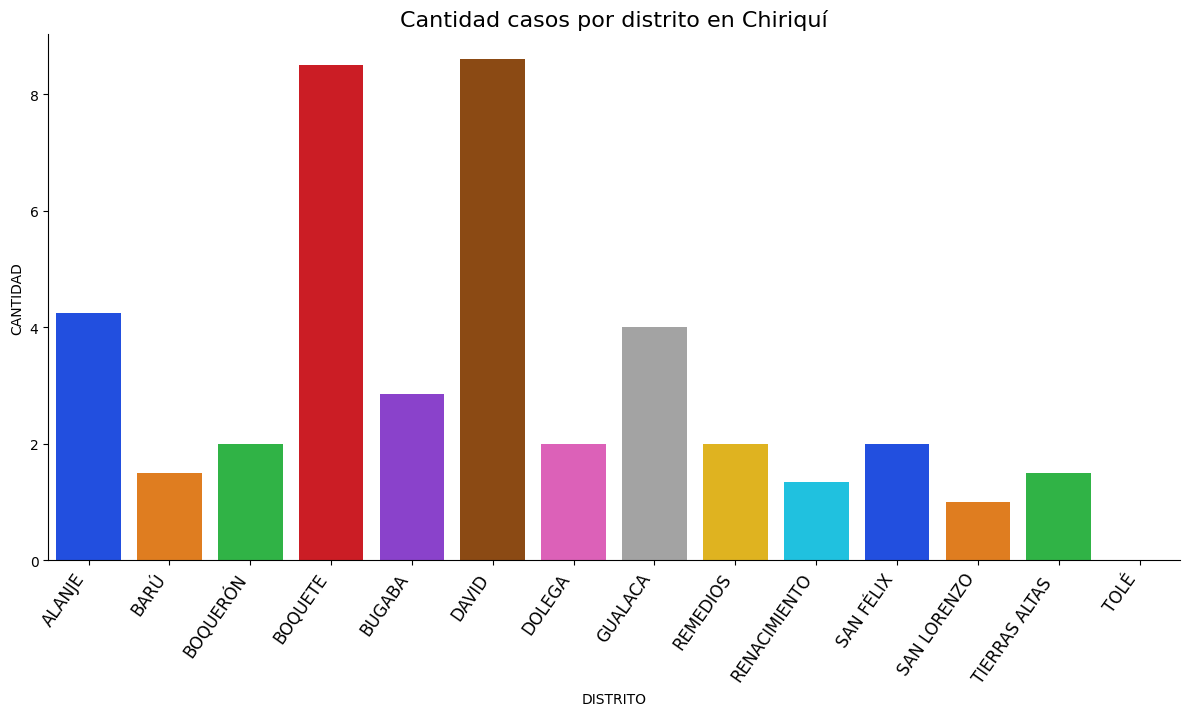

In [13]:
palette = sns.color_palette("bright", n_colors=covid_chiriqui_df['DISTRITO'].nunique())
sns.catplot(
        data = covid_chiriqui_df,
        x = 'DISTRITO',
        y = 'CANTIDAD',
        kind = 'bar',
        hue='DISTRITO',
        palette=palette,
        height = 6,
        aspect = 2,
        legend=False,
        errorbar=None
    )

plt.xticks(rotation=55, fontsize=12, ha='right')
plt.title('Cantidad casos por distrito en Chiriquí', fontsize=16)
plt.show()

In [14]:
covid_chiriqui_by_corregimiento_df = covid_chiriqui_df.groupby('CORREGIMIENTO')[['CANTIDAD', 'HOSPITALIZADO', 'UCI', 'AISLAMIENTO_DOMICILIARIO', 'FALLECIDO', 'RECUPERADO']].sum()
covid_chiriqui_by_corregimiento_df

,CANTIDAD,HOSPITALIZADO,UCI,AISLAMIENTO_DOMICILIARIO,FALLECIDO,RECUPERADO
CORREGIMIENTO,,,,,,
ALANJE (CABECERA),2.0,0.0,0.0,0.0,0.0,2.0
ALTO BOQUETE,14.0,0.0,0.0,12.0,0.0,2.0
ASERRIO DE GARICHE,4.0,0.0,1.0,1.0,0.0,2.0
BACO,0.0,0.0,0.0,0.0,0.0,0.0
BAGALA,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...
TIJERAS,1.0,0.0,0.0,0.0,0.0,1.0
TINAJAS,0.0,0.0,0.0,0.0,0.0,0.0
TOLE (CABECERA),0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
covid_bocas_df = covid_panama_df[covid_panama_df['PROVINCIA'] == 'BOCAS DEL TORO']
covid_bocas_by_distrito_df = covid_bocas_df.groupby('DISTRITO')[['CANTIDAD', 'HOSPITALIZADO', 'UCI', 'AISLAMIENTO_DOMICILIARIO', 'FALLECIDO', 'RECUPERADO']].sum()
covid_bocas_by_distrito_df

,CANTIDAD,HOSPITALIZADO,UCI,AISLAMIENTO_DOMICILIARIO,FALLECIDO,RECUPERADO
DISTRITO,,,,,,
ALMIRANTE,2.0,0.0,0.0,2.0,0.0,0.0
BOCAS DEL TORO,0.0,0.0,0.0,0.0,0.0,0.0
CHANGUINOLA,14.0,0.0,0.0,8.0,0.0,6.0
CHIRIQUÍ GRANDE,37.0,2.0,0.0,34.0,0.0,1.0


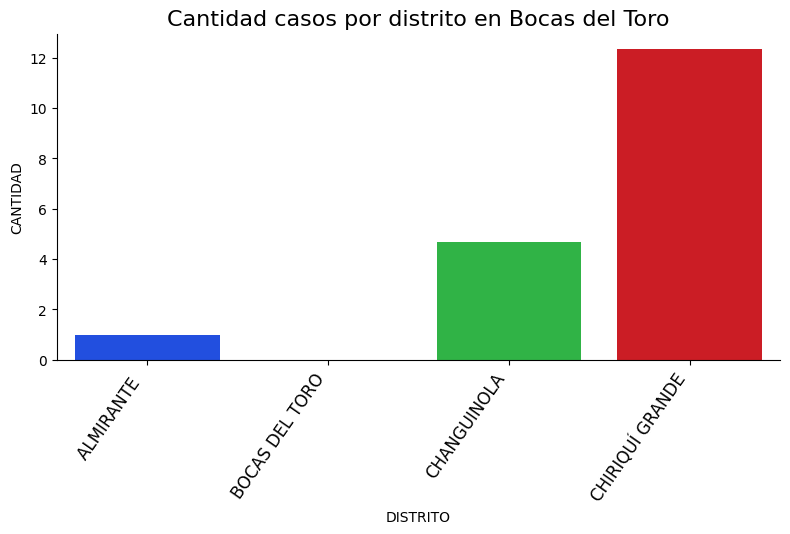

In [16]:
palette = sns.color_palette("bright", n_colors=covid_bocas_df['DISTRITO'].nunique())
sns.catplot(
        data = covid_bocas_df,
        x = 'DISTRITO',
        y = 'CANTIDAD',
        kind = 'bar',
        hue='DISTRITO',
        palette=palette,
        height = 4,
        aspect = 2,
        legend=False,
        errorbar=None
    )

plt.xticks(rotation=55, fontsize=12, ha='right')
plt.title('Cantidad casos por distrito en Bocas del Toro', fontsize=16)
plt.show()

In [17]:
covid_bocas_by_corregimiento_df = covid_bocas_df.groupby('CORREGIMIENTO')[['CANTIDAD', 'HOSPITALIZADO', 'UCI', 'AISLAMIENTO_DOMICILIARIO', 'FALLECIDO', 'RECUPERADO']].sum()
covid_bocas_by_corregimiento_df

,CANTIDAD,HOSPITALIZADO,UCI,AISLAMIENTO_DOMICILIARIO,FALLECIDO,RECUPERADO
CORREGIMIENTO,,,,,,
ALMIRANTE,1.0,0.0,0.0,1.0,0.0,0.0
BAJO CEDRO,0.0,0.0,0.0,0.0,0.0,0.0
BARRIADA 4 DE ABRIL,0.0,0.0,0.0,0.0,0.0,0.0
BARRIADA GUAYMI,1.0,0.0,0.0,1.0,0.0,0.0
BARRIO FRANCES,0.0,0.0,0.0,0.0,0.0,0.0
BASTIMENTOS,0.0,0.0,0.0,0.0,0.0,0.0
BOCAS DEL TORO (CABECERA),0.0,0.0,0.0,0.0,0.0,0.0
CAUCHERO,0.0,0.0,0.0,0.0,0.0,0.0
CHANGUINOLA (CABECERA),6.0,0.0,0.0,4.0,0.0,2.0


## 2. Preparación de los datos

In [18]:
print("Cantidad de datos:\n", covid_panama_df.count())
print("\n")
print("Datos nulos:\n",covid_panama_df.isnull().sum())

Cantidad de datos:
 PROVINCIA                   677
DISTRITO                    677
CORREGIMIENTO               677
CANTIDAD                    228
HOSPITALIZADO               228
AISLAMIENTO_DOMICILIARIO    228
FALLECIDO                   228
UCI                         228
RECUPERADO                  228
LONG                        677
LAT                         677
dtype: int64


Datos nulos:
 PROVINCIA                     0
DISTRITO                      0
CORREGIMIENTO                 0
CANTIDAD                    449
HOSPITALIZADO               449
AISLAMIENTO_DOMICILIARIO    449
FALLECIDO                   449
UCI                         449
RECUPERADO                  449
LONG                          0
LAT                           0
dtype: int64


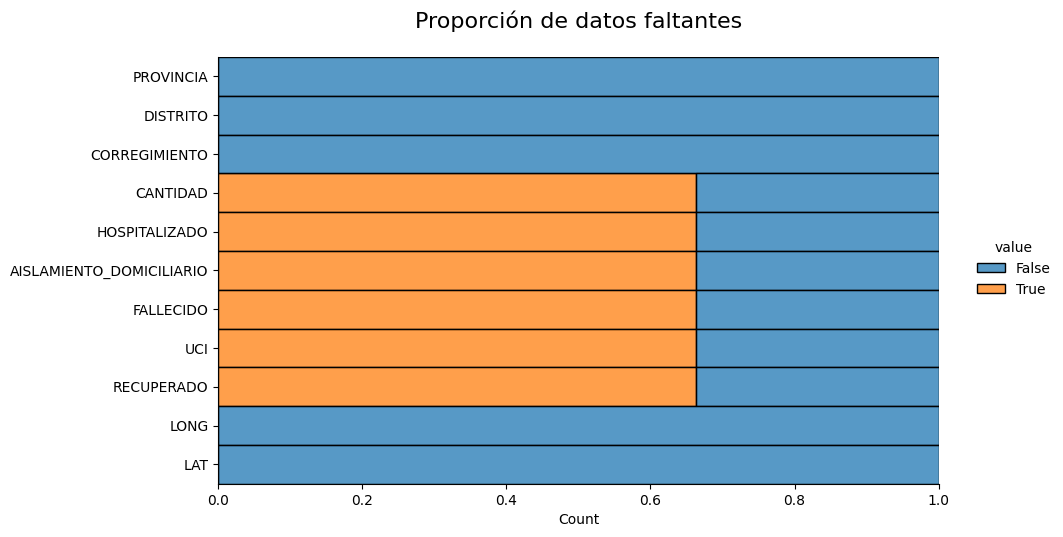

In [19]:
missing = sns.displot(
    data=covid_panama_df.isnull().melt(), 
    y='variable', 
    hue='value', 
    multiple='fill', 
    aspect=2
)


missing.ax.set_title('Proporción de datos faltantes', fontsize=16, y=1.05)
missing.set(ylabel=None)

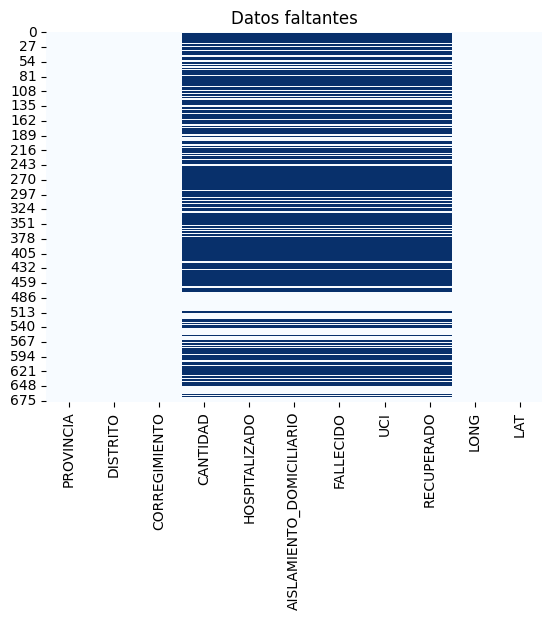

In [20]:
sns.heatmap(covid_panama_df.isnull(), cbar=False, cmap='Blues')
plt.title('Datos faltantes')
plt.show()

### 2.1 Imputacion de datos: Cero en los valores faltantes

In [21]:
covid_panama_imputado_cero_df = covid_panama_df.fillna(0)
print("Datos faltantes luego de la imputación: \n", covid_panama_imputado_cero_df.isnull().sum())

Datos faltantes luego de la imputación: 
 PROVINCIA                   0
DISTRITO                    0
CORREGIMIENTO               0
CANTIDAD                    0
HOSPITALIZADO               0
AISLAMIENTO_DOMICILIARIO    0
FALLECIDO                   0
UCI                         0
RECUPERADO                  0
LONG                        0
LAT                         0
dtype: int64


### 2.2 Imputación de datos: KNN para estimar corregimientos con datos faltantes

In [22]:
faltantes = [
    'CANTIDAD', 'HOSPITALIZADO', 'AISLAMIENTO_DOMICILIARIO',
    'FALLECIDO', 'UCI', 'RECUPERADO'
]

In [23]:
from sklearn.impute import KNNImputer

cols_para_imputacion = faltantes + ['LONG', 'LAT']
df_por_imputar = covid_panama_df[cols_para_imputacion]

index =df_por_imputar.index

scaler = StandardScaler()
df_escalado = pd.DataFrame(scaler.fit_transform(df_por_imputar), columns=cols_para_imputacion, index=index)


imputador = KNNImputer(n_neighbors=6)
df_imputado_escalado = pd.DataFrame(imputador.fit_transform(df_escalado), columns=cols_para_imputacion, index=index)

df_imputado_knn = pd.DataFrame(scaler.inverse_transform(df_imputado_escalado), columns=cols_para_imputacion, index=index)

df_imputado_knn[faltantes] = df_imputado_knn[faltantes].round(0)

covid_panama_imputado_knn_df = covid_panama_df.copy()
covid_panama_imputado_knn_df[cols_para_imputacion] = df_imputado_knn[cols_para_imputacion]

In [24]:
print("Mediana de cantidad de casos, dataset imputado: ", covid_panama_imputado_knn_df['CANTIDAD'].median())
print("Mediana de recuperados, dataset imputado: ",covid_panama_imputado_knn_df['RECUPERADO'].median())

print("Mediana de cantidad de casos, dataset original: ",covid_panama_df['CANTIDAD'].median())
print("Mediana de recuperados, dataset original: ",covid_panama_df['RECUPERADO'].median())
covid_panama_imputado_knn_df.describe()

Mediana de cantidad de casos, dataset imputado:  4.0
Mediana de recuperados, dataset imputado:  1.0
Mediana de cantidad de casos, dataset original:  4.0
Mediana de recuperados, dataset original:  1.0


,CANTIDAD,HOSPITALIZADO,AISLAMIENTO_DOMICILIARIO,FALLECIDO,UCI,RECUPERADO,LONG,LAT
count,677.000000,677.000000,677.000000,677.000000,677.000000,677.000000,677.000000,6.770000e+02
mean,18.307238,0.400295,8.998523,0.395864,0.158050,8.019202,526559.608513,9.321894e+05
std,44.411072,1.991298,17.675117,1.691393,0.711371,24.807446,132405.251236,5.679961e+04
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,288636.430400,8.041394e+05
25%,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,425527.613300,8.877641e+05
50%,4.000000,0.000000,3.000000,0.000000,0.000000,1.000000,537765.387700,9.320807e+05
75%,12.000000,0.000000,8.000000,0.000000,0.000000,3.000000,607056.018900,9.728446e+05
max,460.000000,39.000000,198.000000,19.000000,7.000000,214.000000,895852.727200,1.061314e+06


## 3. Feature Engineering

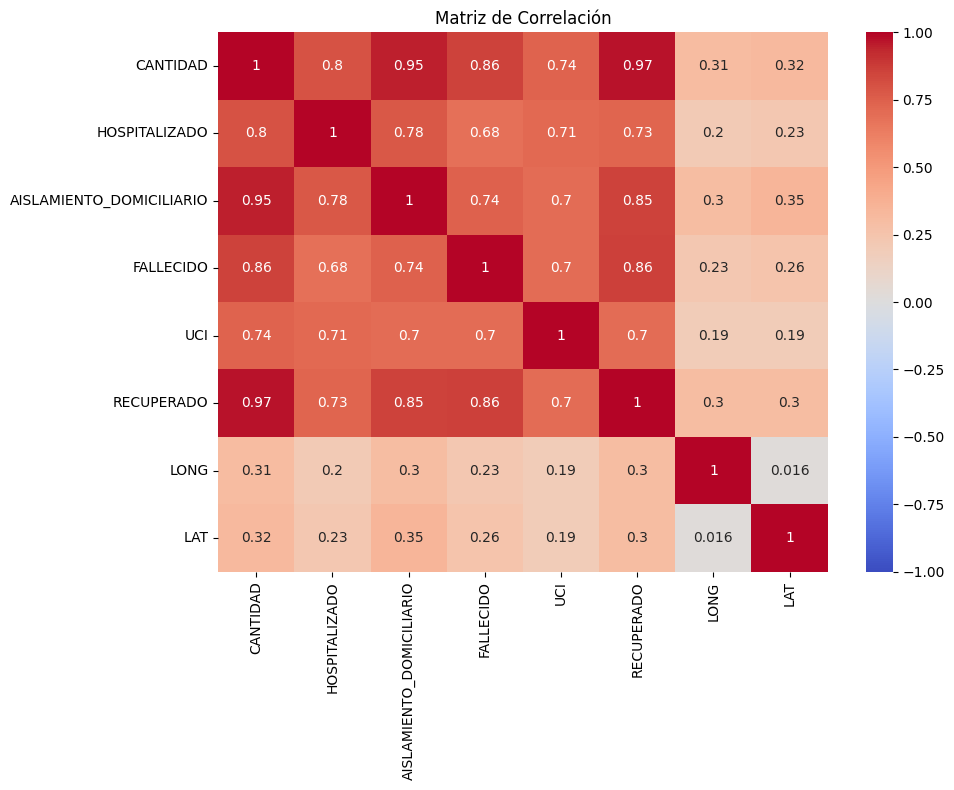

In [25]:
covid_panama_numericos_knn_df = covid_panama_imputado_knn_df.select_dtypes(include=['float64'])
corr = covid_panama_numericos_knn_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Matriz de Correlación')
plt.tight_layout()
plt.show()

Se agregará RATIO HOSPITALIZADOS (HOSP/CANT), RATIO AISLAMIENTO_DOM (AISL/CANT), SEVERIDAD ((UCI+FALLECIDO)/CANTIDAD)

In [26]:
covid_panama_features_0_df = covid_panama_imputado_cero_df.copy()
covid_panama_features_knn_df = covid_panama_imputado_knn_df.copy()

covid_panama_features_0_df = funciones.agrega_caracteristicas(covid_panama_imputado_cero_df)
covid_panama_features_knn_df = funciones.agrega_caracteristicas(covid_panama_imputado_knn_df)

## 4. División del dataset y Validación Cruzada

Nuestra variable objetivo es RECUPERADO

In [27]:
covid_chiriqui_0 = covid_panama_features_0_df[covid_panama_features_0_df['PROVINCIA'] == 'CHIRIQUÍ']
covid_chiriqui_knn = covid_panama_features_knn_df[covid_panama_features_knn_df['PROVINCIA'] == 'CHIRIQUÍ']

covid_bocas_0 = covid_panama_features_0_df[covid_panama_features_0_df['PROVINCIA'] == 'BOCAS DEL TORO']
covid_bocas_knn = covid_panama_features_knn_df[covid_panama_features_knn_df['PROVINCIA'] == 'BOCAS DEL TORO']

In [28]:
ver_dependiente = 'RECUPERADO'

vars_indeps = ['RATIO_HOSPITALIZADOS', 'RATIO_AISLAMIENTO', 'SEVERIDAD']
vars_indeps_og = ['CANTIDAD', 'HOSPITALIZADO', 'AISLAMIENTO_DOMICILIARIO', 'FALLECIDO', 'UCI']

vars_ind_todas = ['RATIO_HOSPITALIZADOS', 'RATIO_AISLAMIENTO', 'SEVERIDAD', 'LONG', 'LAT']
vars_ind_todas_og = ['CANTIDAD', 'HOSPITALIZADO', 'AISLAMIENTO_DOMICILIARIO', 'FALLECIDO', 'UCI', 'LONG', 'LAT']


datasets = [
    covid_bocas_0,
    covid_bocas_knn,
    covid_chiriqui_0,
    covid_chiriqui_knn
    ]

datasets_preparados = []


for df in datasets:
    X_train, X_test, y_train, y_test = funciones.prepara_el_dataset(
        df, 
        ver_dependiente, 
        vars_indeps,
        test_size=0.22
        )

    datasets_preparados.append({
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    })

In [29]:
## VALIDACION DE LINEAR REGRESSION

resultados_de_validaciones_lr = []

for i, dataset in enumerate(datasets_preparados):

    X_train = dataset['X_train']
    y_train = dataset['y_train']

    resultado = funciones.validacion_cruzada(X_train, y_train, modelo=LinearRegression(), cv=5)
    
    resultados_de_validaciones_lr.append(resultado)

for i, resultado in enumerate(resultados_de_validaciones_lr):
    print(resultado)

{'MSE train': 0.372, 'MSE avg CV': 0.467, 'Std CV MSE': 0.667, 'R2 train': 0.137, 'R2 avg CV': -0.193}
{'MSE train': 0.114, 'MSE avg CV': 0.372, 'Std CV MSE': 0.513, 'R2 train': 0.76, 'R2 avg CV': 0.307}
{'MSE train': 0.37, 'MSE avg CV': 0.548, 'Std CV MSE': 0.605, 'R2 train': 0.058, 'R2 avg CV': -0.229}
{'MSE train': 4.972, 'MSE avg CV': 96.414, 'Std CV MSE': 179.754, 'R2 train': 0.141, 'R2 avg CV': -161.659}


In [30]:
## VALIDACION DE kNN


resultados_de_validaciones_knn = []

for i, dataset in enumerate(datasets_preparados):

    X_train = dataset['X_train']
    y_train = dataset['y_train']

    resultado = funciones.validacion_cruzada(X_train, y_train, modelo=KNeighborsRegressor(), scaling=True, cv=5, n_neighbors=4)
    
    resultados_de_validaciones_knn.append(resultado)

for i, resultado in enumerate(resultados_de_validaciones_knn):
    print(resultado)

{'MSE train': 0.212, 'MSE avg CV': 0.487, 'Std CV MSE': 0.729, 'R2 train': 0.508, 'R2 avg CV': 0.267}
{'MSE train': 0.185, 'MSE avg CV': 0.275, 'Std CV MSE': 0.364, 'R2 train': 0.609, 'R2 avg CV': 0.467}
{'MSE train': 0.195, 'MSE avg CV': 0.445, 'Std CV MSE': 0.469, 'R2 train': 0.504, 'R2 avg CV': 0.032}
{'MSE train': 3.669, 'MSE avg CV': 5.748, 'Std CV MSE': 9.513, 'R2 train': 0.366, 'R2 avg CV': -0.526}


## 5-6. Modelado y Evaluación

In [31]:
## MODELO REGRESION LINEAL

resultados_de_regresiones_lr = []

for i, dataset in enumerate(datasets_preparados):

    X_train = dataset['X_train']
    X_test = dataset['X_test']
    y_train = dataset['y_train']
    y_test = dataset['y_test']
    
    resultado = funciones.regresor(X_train, X_test, y_train, y_test, modelo=LinearRegression(), scaling=True)
    
    resultados_de_regresiones_lr.append(resultado)

for i, resultado in enumerate(resultados_de_regresiones_lr):
    print(resultado)

{'Modelo': 'LinearRegression', 'MSE': 0.393, 'RMSE': 0.627, 'MAE': 0.391, 'R2': 0.198}
{'Modelo': 'LinearRegression', 'MSE': 0.049, 'RMSE': 0.221, 'MAE': 0.22, 'R2': 0.881}
{'Modelo': 'LinearRegression', 'MSE': 2.489, 'RMSE': 1.578, 'MAE': 0.794, 'R2': 0.118}
{'Modelo': 'LinearRegression', 'MSE': 1.738, 'RMSE': 1.318, 'MAE': 0.944, 'R2': 0.286}


In [32]:
## MODELO KNN


resultados_de_regresiones_knn = []

for i, dataset in enumerate(datasets_preparados):

    X_train = dataset['X_train']
    X_test = dataset['X_test']
    y_train = dataset['y_train']
    y_test = dataset['y_test']
    
    resultado = funciones.regresor(X_train, 
    X_test, 
    y_train, 
    y_test, 
    modelo=KNeighborsRegressor(), 
    scaling=True, 
    n_neighbors=7)
    
    resultados_de_regresiones_knn.append(resultado)

for i, resultado in enumerate(resultados_de_regresiones_knn):
    print(resultado)

{'Modelo': 'KNeighborsRegressor', 'MSE': 0.309, 'RMSE': 0.556, 'MAE': 0.286, 'R2': 0.369}
{'Modelo': 'KNeighborsRegressor', 'MSE': 0.149, 'RMSE': 0.386, 'MAE': 0.184, 'R2': 0.636}
{'Modelo': 'KNeighborsRegressor', 'MSE': 1.887, 'RMSE': 1.374, 'MAE': 0.528, 'R2': 0.152}
{'Modelo': 'KNeighborsRegressor', 'MSE': 1.256, 'RMSE': 1.121, 'MAE': 0.783, 'R2': 0.484}


## 7. Conclusiones

1. El modelo KNN presentó una mejor generalización sobre el modelo de regresión lineal.
2. Se pudo lograr un coeficiente de correlación cercano o superior a 0.5 para ambos modelos.
3. Para estos modelos, la imputación por KNN resultó ser más efectiva que imputar con ceros.
4. Las características generadas ayudaron a minimizar el sobreajuste de los modelos.
5. Las características geográficas no ayudaron a mejorar la precisión de los modelos.
6. Los modelos se beneficiarían de una mayor cantidad de datos para estimar mejor.